In [4]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

server = "localhost,5432"
db_name = "ModMon"
driver = "/usr/local/lib/psqlodbcw.so"

cnxn = pyodbc.connect("DRIVER={" + driver + "};SERVER=" + server + ";DATABASE=" + db_name + ";Trusted_Connection=yes;")
cursor = cnxn.cursor()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
query = """
        SELECT m.name AS Model, mv.modelversion AS active_version, Q.description AS Question, m.teamName AS Team
        FROM modelVersions as mv, models AS m, researchQuestions AS q
        WHERE m.questionID = q.questionID
        AND mv.modelid = m.modelid
        AND mv.active;
        """
metadata = pd.read_sql(
            query,
            cnxn,
        )
metadata

,model,active_version,question,team
0,synpuf_stats,0.0.1,Descriptive stats for Synpuf database,REG
1,synpuf-python,0.1,Predict the gender of patients,The A-Team
2,synpuf-R,1.0,Predict the gender of patients,Another Team


Visualisation ideas
==

In [13]:
results_table = pd.read_sql('SELECT * FROM results;', cnxn)
results_table.head()

,modelid,modelversion,testdatasetid,isreferenceresult,runtime,runid,metric,value,valueerror,resultmessage
0,1,0.0.1,2,1,2020-01-01,1,jan_births,23.0,None,None
1,1,0.0.1,2,1,2020-01-01,1,aug_births,13.0,None,None
2,1,0.0.1,2,1,2020-01-01,1,born_60,1.0,None,None
3,1,0.0.1,2,1,2020-01-01,1,population_size,200.0,None,None
4,1,0.0.1,2,1,2020-01-01,1,mortality,5.0,None,None


In [17]:
models.describe()

,modelid
count,3.0
mean,2.0
std,1.0
min,1.0
25%,1.5
50%,2.0
75%,2.5
max,3.0


[Text(0, 0.5, 'Runs in ModMon DB'), Text(0.5, 0, 'Model')]

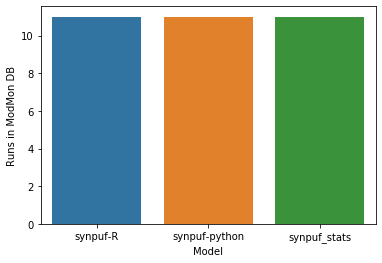

In [7]:
# Number of times each model has been run
query = """
SELECT m.name, COUNT( DISTINCT r.runid )
FROM results AS r, models AS m
WHERE r.modelid = m.modelid
GROUP BY m.name;
"""
data = pd.read_sql(query, cnxn)
bar = sns.barplot(x='name', y='count', data=data)
bar.set(xlabel='Model', ylabel="Runs in ModMon DB")

In [10]:
query = """
SELECT m.name, r.metric, r.value, d.databasename, d.datasetid, m.modelid, r.modelversion, q.description
FROM results AS r, datasets AS d, models AS m, researchQuestions AS q
WHERE r.testdatasetid = d.datasetid
AND r.modelid = m.modelid
AND m.questionid = q.questionid;
"""
results = pd.read_sql(query, cnxn)
results = results.sort_values(by=['modelid', 'datasetid'])
results

,name,metric,value,databasename,datasetid,modelid,modelversion,description
10,synpuf_stats,jan_births,23.000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
11,synpuf_stats,aug_births,13.000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
12,synpuf_stats,born_60,1.000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
13,synpuf_stats,population_size,200.000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
14,synpuf_stats,mortality,5.000,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database
...,...,...,...,...,...,...,...,...
89,synpuf-python,AUC,0.513,WEEK_08,13,3,0.1,Predict the gender of patients
98,synpuf-python,accuracy,0.522,WEEK_09,14,3,0.1,Predict the gender of patients
99,synpuf-python,AUC,0.513,WEEK_09,14,3,0.1,Predict the gender of patients
108,synpuf-python,accuracy,0.522,WEEK_10,15,3,0.1,Predict the gender of patients


In [11]:
results['model'] = results['name'] + '_' + results['modelversion']
results['titles'] = results['metric'] + ' (' + results['description'] + ')'
results.head()

,name,metric,value,databasename,datasetid,modelid,modelversion,description,model,titles
10,synpuf_stats,jan_births,23.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,jan_births (Descriptive stats for Synpuf datab...
11,synpuf_stats,aug_births,13.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,aug_births (Descriptive stats for Synpuf datab...
12,synpuf_stats,born_60,1.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,born_60 (Descriptive stats for Synpuf database)
13,synpuf_stats,population_size,200.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,population_size (Descriptive stats for Synpuf ...
14,synpuf_stats,mortality,5.0,WEEK_01,1,1,0.0.1,Descriptive stats for Synpuf database,synpuf_stats_0.0.1,mortality (Descriptive stats for Synpuf database)


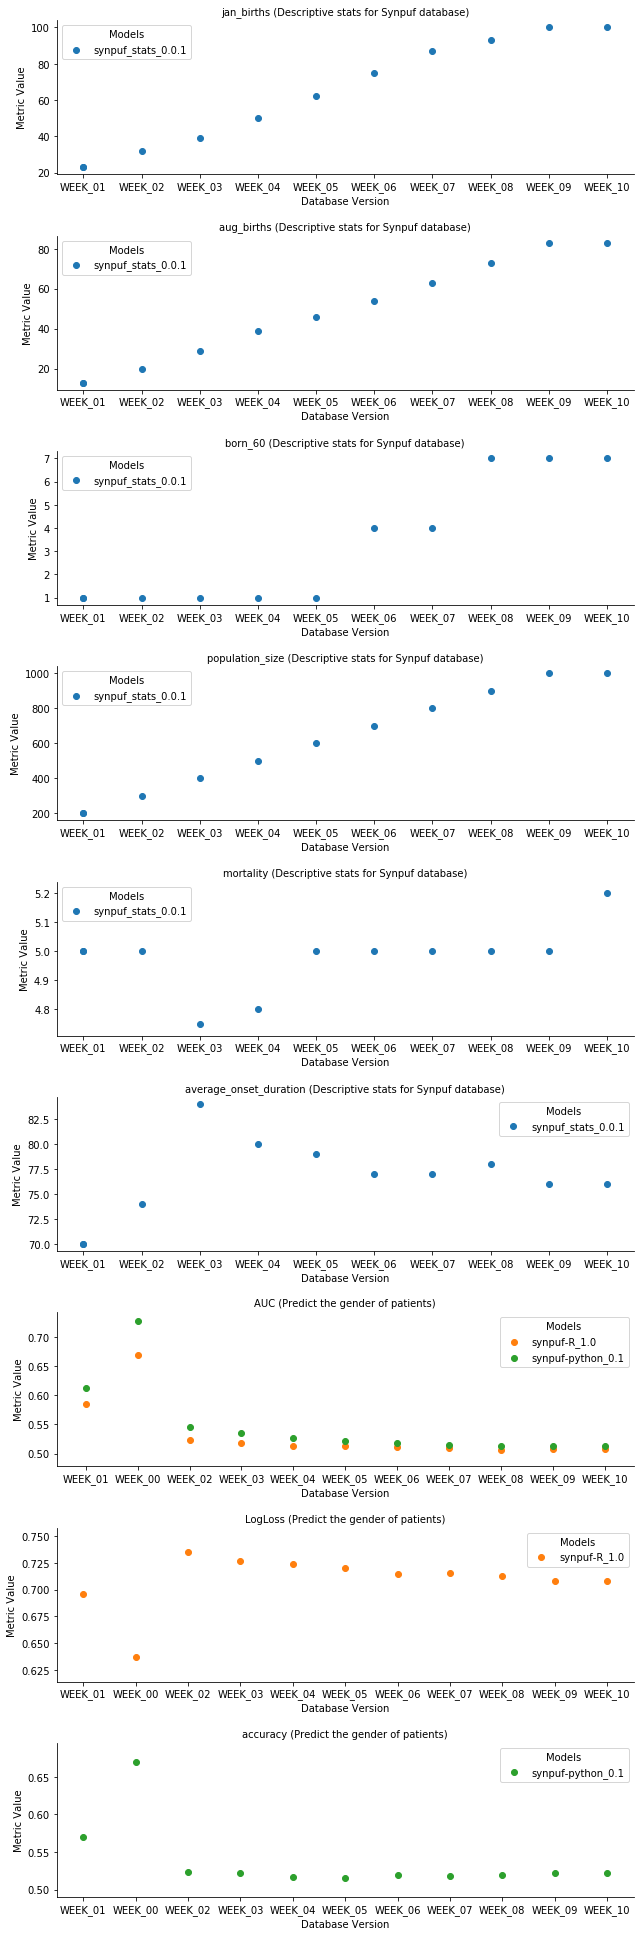

In [12]:
g = sns.FacetGrid(data=results, row='titles', sharey=False, sharex=False, aspect=3, hue='model')
g.map(plt.scatter, "databasename", "value").fig.subplots_adjust(hspace=.4)
g.set(xlabel='Database Version', ylabel='Metric Value')
g.set_titles(col_template = "{col_name}", row_template = '{row_name}')
for i, _ in enumerate(g.axes):
    g.axes[i][0].legend(title = "Models")